# Trabajo Práctico 2
## Alumnos
Aguirregaray, Mauro
Denardi, Fabricio

## Cohorte
15-2024

###  Consideraciones generales
1. Siempre que lo consideramos necesario, realizamos un tipado de las funciones como una explicación detallada.
2. Intentamos nomenclar siempre en inglés variables, métodos, clases etc, aunque para un mejor entendimiento los comentarios los hicimos en español.


## Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
Medición sobre todo el frame.

In [77]:
%matplotlib  inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import os
import time
import copy

### 3. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

In [78]:
def get_center(height:int, width:int, roi_percentage:float=0.05) -> tuple:
    '''Devuelve las coordenadas del centro'''
    total_area = height * width
    roi_area = roi_percentage * total_area
    
    # Calcular el tamaño de la ROI
    roi_size = int(np.sqrt(roi_area)) #Se asume por simplicidad y ante falta de especificación en el enunciado que será cuadrada
    
    # Calcular las coord
    cx, cy = width // 2, height // 2  # Coordenadas del centro de la imagen
    x1, y1 = cx - roi_size // 2, cy - roi_size // 2  # Corner superior izquierdo
    x2, y2 = cx + roi_size // 2, cy + roi_size // 2  # Corner inferior derecho
    
    # Evitar desbordes
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(width, x2), min(height, y2)
    
    return x1,y1,x2,y2

In [79]:
def get_center_roi(image: np.ndarray, roi_percentage:float=0.05) -> np.ndarray:
    '''Devuelve la región central que ocupe un % pasado como parámetro'''
    
    if not (0.05 <= roi_percentage <= 0.10):
        raise ValueError("El porcentaje de ROI debe estar entre 5% y 10%.") 

    # Obtener las dimensiones del área
    height, width = image.shape[:2]
    
    x1,y1,x2,y2 = get_center(height,width,roi_percentage)

    # ROI
    roi = image[y1:y2, x1:x2]
    return roi 


In [80]:
def calculate_grid_size_and_padding(image_size, cell_size, spacing):
    image_height, image_width = image_size
    cell_height, cell_width = cell_size
    
    num_cells_x = (image_width - cell_width) // (cell_width + spacing) + 1
    num_cells_y = (image_height - cell_height) // (cell_height + spacing) + 1
    
    return num_cells_x, num_cells_y

In [81]:
def calculate_spacing(image_size, cell_size, num_cells_x, num_cells_y):
    '''Calculamos el espacio entre celdas'''
    image_height, image_width = image_size
    cell_height, cell_width = cell_size
    
    total_width = num_cells_x * cell_width
    total_height = num_cells_y * cell_height
    
    spacing_x = (image_width - total_width) // (num_cells_x + 1)
    spacing_y = (image_height - total_height) // (num_cells_y + 1)
    
    return spacing_x, spacing_y

In [82]:
def get_grid_regions(image:np.ndarray, N:int, M:int,cell_size = (10, 10)):
    '''Calcula las regiones'''
    image_height, image_width = image.shape[:2]
    cell_height, cell_width = cell_size
    
    spacing_x, spacing_y = calculate_spacing((image_height, image_width), cell_size, N, M)
    
    grid_elements = []
    
    for i in range(M):
        for j in range(N):
            start_x = j * (cell_width + spacing_x) + spacing_x
            start_y = i * (cell_height + spacing_y) + spacing_y
            end_x = start_x + cell_width
            end_y = start_y + cell_height
            
            if end_x <= image_width and end_y <= image_height:
                grid_elements.append((image[start_y:end_y, start_x:end_x], (start_x, start_y, end_x, end_y)))
    
    return grid_elements #Me devuelve una lista de imágenes


In [83]:
def get_fm_metric_for_grid(fm_metric_array: list):
    return np.mean(fm_metric_array)

In [84]:
def calculate_image_quality_measure_FM(img:np.ndarray) -> float:

    #Step 1: Compute F which is the Fourier Transform representation of image I 
    image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    f = np.fft.fft2(image_gray)

    #Step 2:  Find Fc which is obtained by shifting the origin of F to centre. 
    fc = np.fft.fftshift(f)

    #Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I. 
    af = np.abs(fc)

    #Step 4:  Calculate M = max (AF) where M is the maximum value of the frequency component in F. 
    m = np.max(af)

    #Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    threshold = m / 1000
    th = np.sum(af > threshold)

    #Step 6: Calculate Image Quality measure (FM) from equation (1).
    fm = th / m

    return fm    

In [85]:
def get_frames(video_path):
    cap = cv.VideoCapture(video_path)
    frames = []

    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()

    

    return frames, height, width,fps

In [86]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
roi_center_percentage = 0.05
region_nxm_to_analize = {"(3,3)":[(3,3),[],[]],"(7,5)":[(7,5),[],[]],"(9,6)":[(9,6),[],[]]}


print(f"Cantidad de frames del video {video_name}: {len(frames)}")

fm_all_frame_video = []
fm_center_video = []
for frame in frames:
    fm_all_frame = calculate_image_quality_measure_FM(frame)
    fm_all_frame_video.append(fm_all_frame)
    
    fm_center = calculate_image_quality_measure_FM(get_center_roi(frame,roi_center_percentage))
    fm_center_video.append(fm_center)
    
    for k,v in region_nxm_to_analize.items():
        #Obtener las regiones segun la matriz a analizar
        regions = get_grid_regions(frame,v[0][0],v[0][1])

        regions_coords = []
        tmp_fm = []
        for region in regions:
            tmp_fm.append(calculate_image_quality_measure_FM(region[0]))
            regions_coords.append(region[1])

        total_fm_region = get_fm_metric_for_grid(tmp_fm)
        region_nxm_to_analize[k][1].append(total_fm_region)
        #region_nxm_to_analize[k][2].append(regions_coords)

[ WARN:0@2106.819] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@2106.819] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin11 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@2106.819] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@2106.819] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/

Cantidad de frames del video focus_video.mov: 171


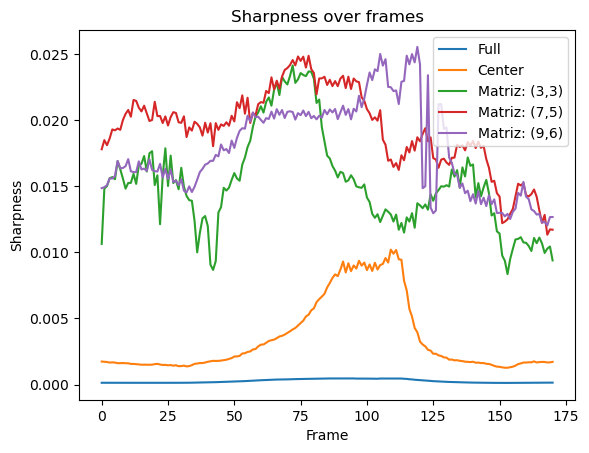

In [87]:
# Graficar las curvas de nitidez (Sharpness)
plt.plot(fm_all_frame_video, label='Full')
plt.plot(fm_center_video, label='Center')

for k,v in region_nxm_to_analize.items():
    plt.plot(v[1], label=f'Matriz: {k}')

plt.legend()
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames')
plt.show()

In [88]:
def remove_file_if_exists(file_path:str):
    '''Elimina archivo en caso que exista'''
    if os.path.exists(file_path):
        os.remove(file_path)

In [89]:
def get_sharpness_values_umbral(sharpness_values, sigma = 3):
    '''mean_sharpness = np.mean(sharpness_values)
    std_dev_sharpness = np.std(sharpness_values)
    lower_bound = mean_sharpness - sigma * std_dev_sharpness
    upper_bound = mean_sharpness + sigma * std_dev_sharpness'''

    max_sharpness = np.max(sharpness_values)
   
    lower_bound = max_sharpness - sigma * max_sharpness
    upper_bound = max_sharpness + sigma * max_sharpness


    return lower_bound, upper_bound

In [90]:
def build_video(frames, sharpness_values, output_path, regions, region_line_widht = 2, tolerance=0.1, ok_color = (0, 255, 0), no_ok_color = (0, 0, 255)):
    remove_file_if_exists(output_path)

    lower_bound, upper_bound = get_sharpness_values_umbral(sharpness_values,tolerance)


    height, width = frames[0].shape[:2]
    fps = video_fps  

    # Salida de video
    fourcc = cv.VideoWriter_fourcc(*'avc1')
    out = cv.VideoWriter(output_path, fourcc, fps, (width, height))

    for idx, frame in enumerate(frames):

        color = ok_color if lower_bound <= sharpness_values[idx] <= upper_bound else no_ok_color

        for (x1, y1, x2, y2) in regions:
            cv.rectangle(frame, (x1, y1), (x2, y2), color, region_line_widht)

        out.write(frame)

    out.release()

    # Espera para asegurar que el buffer se vacíe. A pesar del release nos mezclaba los videos
    time.sleep(2)

In [91]:
def get_out_file_name(file):
    '''Devuelve el path relativo'''
    return os.path.join('outs',file)

In [97]:
#Todo el frame
all_frame_region = [(0,0,video_width, video_height)] # Única región (x1, y1, x2, y2)

#Centro
x1, y1, x2, y2 = get_center(video_height,video_width)
centered_frame_region = [(x1, y1, x2, y2)] 

all_frames = copy.deepcopy(frames)
build_video(all_frames, fm_all_frame_video,get_out_file_name('out_all_frame.mp4'),all_frame_region, region_line_widht=6)

centered_frames = copy.deepcopy(frames)
build_video(centered_frames, fm_center_video,get_out_file_name('centered_all_frame.mp4'),centered_frame_region, region_line_widht=2, tolerance=0.3)



for k,v in region_nxm_to_analize.items():
    region_frames = copy.deepcopy(frames)
    regions = [x[1] for x in get_grid_regions(region_frames[0], v[0][0], v[0][1])]

    build_video(region_frames, fm_center_video,get_out_file_name(f'{k}_frame.mp4'),regions, region_line_widht=1, tolerance=0.3)
 


(<unknown>:50467): GStreamer-CRITICAL **: 19:02:47.645: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@3218.780] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: A

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure 
operators in shapefrom focus.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera 
automática.

Puntos extra: Aplicar unsharp masking para expandir la zona de enfoque y devolver.